# Coal thermodynamic data and equilibrium

## Thermodynamic data

* Set NASA polynomial coefficients for coal.
    * [Coefficient forms](https://cantera.org/science/science-species.html)
    
    $$\frac{c_p(T)}{R} = a_0 + a_1T + a_2T^2 + a_3T^3 + a_4T^4,$$
    
    $$\frac{H(T)}{RT} = a_0 + \frac{a_1}{2}T + \frac{a_2}{3}T^2 + \frac{a_3}{4}T^3 + \frac{a_4}{5}T^4+\frac{a_5}{T},$$
    
    $$\frac{S(T)}{R} = a_0\ln(T) + a_1T + \frac{a_2}{2}T^2 + \frac{a_3}{3}T^3 + \frac{a_4}{4}T^4+a_6.$$
    
* Coal heat capacity correlation: [D. Merrick, Fuel 62(5):540-546 (1983)](https://www.sciencedirect.com/science/article/pii/0016236183902235)
* Coal entropy correlation: [W. Eisermann et al., Fuel Processing Technology 3(1):39-53 (1980)](https://www.sciencedirect.com/science/article/pii/0378382080900223)
* The NASA polynomial coefficients are then used to create a coal.cti file for use in Cantera. 
* Note, the NASA correlations are given separately in low and high temperature regions. Coefficients in the high temperature region are constrained to give continuity between the regions.

## Equilibrium

* Use Cantera to compute solid-gas equilibrium between coal and oxidizer.
    * Equilibrium with coal is difficult in Cantera because you cannot specify the elements and enthalpy directly, you need to specify an initial gas state. One can easily specify gas species that have the correct coal (and gas) elemental composition, but these species together with the enthalpy can give nonphysical temperatures. 
    * It is easier to specify the coal directly and equilibrate a two-phase mixture. 
    * Except under very rich conditions, only a gas will be present at equilibrium, but the two phase specification eases the problem specification.
* Note that the coal entropy correlation is only relevant in cases where solid coal is present *at equilibrium*.
    * This is also true of coal heat capacity, since the enthalpy magnitude is not dependent on the heat capacity value.
    

## Thermodynamic data
### User input

In [1]:
Hf   = -5560787.0400    # coal heat of formation: J/kmol at Tref
Tref = 298.15           # K
CHONS_massfrac = np.array([0.7806, 0.0492, 0.0965, 0.0150, 0.0587]) # Dry Ash-Free

### Calculation

cp_lo(Tmid)-cp_hi(Tmid) = 0.000000e+00
h_fit(Tmid)-h_fit(Tmid) = 0.000000e+00
s_fit(Tmid)-s_fit(Tmid) = 0.000000e+00

Low, Mid, High temperatures:  200.0 1000.0 5000.0

NASA coefficients: Low:
[ 6.033158685e-02 -6.505023946e-05  1.520548914e-06 -1.991144552e-09
  7.866843274e-13 -6.937760735e+02  9.376005961e-01]

NASA coefficients: High:
[ 1.790808818e-01  2.041593390e-04 -8.742278043e-08  1.674137487e-11
 -1.188777889e-15 -7.555364533e+02  1.797587638e-01]


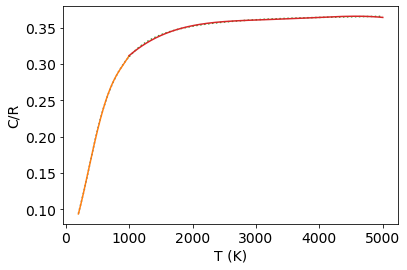

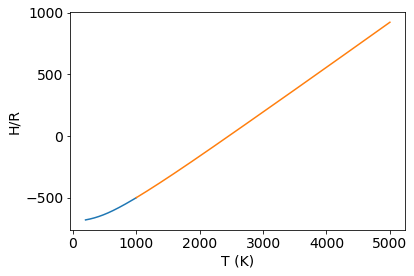

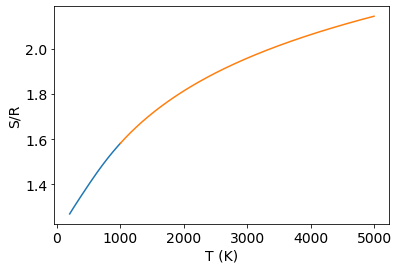

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
#import cantera as ct             # not necessary here

#######################################################################

########### Get mean atomic weight of coal

CHONS_kmol = CHONS_massfrac.copy()  # kmols elements for 1 kg coal basis
CHONS_kmol[0] /= 12.011      # C   12.011 = ct.Element('C').weight if using Cantera here
CHONS_kmol[1] /= 1.00794     # H
CHONS_kmol[2] /= 15.9994     # O
CHONS_kmol[3] /= 14.00674    # N
CHONS_kmol[4] /= 32.066      # S

Ma = 1.0/np.sum(CHONS_kmol)          # mean atomic weight of coal

CHONS_molefrac = CHONS_kmol/np.sum(CHONS_kmol)

########### Heat capacity

def cR(T):        # = c/R = nondimensional heat capacity from Merrick
    def g(z):
        return np.exp(z)/((np.exp(z)-1)/z)**2
    return (g(380./T) + 2*g(1800/T)) / Ma

def cp_fit(T, a0, a1, a2, a3, a4):  # = c/R: NASA form
    return a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4

def cp_fit_hi(T, a1, a2, a3, a4):       # constrained to match lo T region
    y = a1*Tmid + a2*Tmid**2 + a3*Tmid**3 + a4*Tmid**4
    a0 = cp_fit(Tmid, *coefs_lo) - y
    return a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4

#----------------------------------------------

Tlo  = 200.0       # lower temperature bound of the fit (K)
Tmid = 1000.0      # intermediate temperature between the lo T and hi T regions
Thi  = 5000.0      # upper bound of the fit (K)

T_lo = np.linspace(Tlo,Tmid,1000)   # range of temperatures for fitting/plotting
c_lo = cR(T_lo)                     # Merrick correlation in the 

T_hi = np.linspace(Tmid,Thi,1000)
c_hi = cR(T_hi)

coefs_lo, _ = curve_fit(cp_fit   , T_lo, c_lo)   # NASA coefficients
coefs_hi, _ = curve_fit(cp_fit_hi, T_hi, c_hi)

#------------- recover a0 coefficient for hi temp region and add to coefs_hi

a1, a2, a3, a4 = coefs_hi
y = a1*Tmid + a2*Tmid**2 + a3*Tmid**3 + a4*Tmid**4
a0 = cp_fit(Tmid, *coefs_lo) - y
coefs_hi = np.insert(coefs_hi, 0, a0)

#------------- plot cp results

plt.rc('font', size=14)

fig, ax = plt.subplots(1,1)

plt.plot(T_lo,c_lo, ':')
plt.plot(T_lo,cp_fit(T_lo, *coefs_lo), '-')

plt.plot(T_hi,c_hi, ':')
plt.plot(T_hi,cp_fit(T_hi, *coefs_hi), '-');

plt.xlabel('T (K)')
plt.ylabel('C/R')

print(f"cp_lo(Tmid)-cp_hi(Tmid) = {cp_fit(Tmid, *coefs_lo) - cp_fit(Tmid, *coefs_hi):3e}")  # test region continuity

########### Enthalpy: get a5 coefficient: lo and hi

def h_fit(T, a0, a1, a2, a3, a4, a5):   # H/R
    return a0*T + a1/2*T**2 + a2/3*T**3 + a3/4*T**4 + a4/5*T**5 + a5

Rgas = 8314.4621      # ct.gas_constant
a0, a1, a2, a3, a4 = coefs_lo
a5_lo = Hf/Rgas - (a0*Tref + a1/2*Tref**2 + a2/3*Tref**3 + a3/4*Tref**4 + a4/5*Tref**5)
coefs_lo = np.append(coefs_lo, a5_lo)
a0, a1, a2, a3, a4 = coefs_hi
a5_hi = h_fit(Tmid, *coefs_lo) - (a0*Tmid + a1/2*Tmid**2 + a2/3*Tmid**3 + a3/4*Tmid**4 + a4/5*Tmid**5) 
coefs_hi = np.append(coefs_hi, a5_hi)

#------------- plot results

fig, ax = plt.subplots(1,1)

plt.plot(T_lo, h_fit(T_lo, *coefs_lo))
plt.plot(T_hi, h_fit(T_hi, *coefs_hi))

plt.xlabel('T (K)')
plt.ylabel('H/R');

print(f"h_fit(Tmid)-h_fit(Tmid) = {h_fit(Tmid, *coefs_lo) - h_fit(Tmid, *coefs_hi):3e}")  # test region continuity

########### Entropy: get a6 coefficient: lo and hi

def Sformation(CHONS):      # J/kmol correlation from Eisermann
    C = CHONS[0]
    H = CHONS[1]
    O = CHONS[2]
    N = CHONS[3]
    S = CHONS[4]
    
    a1 = 37.1653
    a2 = -31.4767
    a3 = 0.564682
    a4 = 20.1145
    a5 = 54.3111
    a6 = 44.6712
    
    S = (a1 + a2*np.exp(-a3*(H/C + N)) + a4*O/(C+N) + a5*N/(C+N) + a6*S/(C+N))  # kJ/kmol_carbon K
    return S*1000.0 * C     # kJ/kmol_coal K

def s_fit(T, a0, a1, a2, a3, a4, a5, a6):   # S/R
    return a0*np.log(T) + a1*T + a2*T**2/2 + a3*T**3/3 + a4*T**4/4 + a6

Sf = Sformation(CHONS_molefrac)      # J/kmol at Tref

a0, a1, a2, a3, a4, a5 = coefs_lo
a6_lo = Sf/Rgas - (a0*np.log(Tref) + a1*Tref + a2*Tref**2/2 + a3*Tref**3/3 + a4*Tref**4/4)
coefs_lo = np.append(coefs_lo, a6_lo)
a0, a1, a2, a3, a4, a5 = coefs_hi
a6_hi = s_fit(Tmid, *coefs_lo) - (a0*np.log(Tmid) + a1*Tmid + a2*Tmid**2/2 + a3*Tmid**3/3 + a4*Tmid**4/4)
coefs_hi = np.append(coefs_hi, a6_hi)

print(f"s_fit(Tmid)-s_fit(Tmid) = {s_fit(Tmid, *coefs_lo) - s_fit(Tmid, *coefs_hi):3e}")  # test region continuity

#------------- plot results

fig, ax = plt.subplots(1,1)

plt.plot(T_lo, s_fit(T_lo, *coefs_lo))
plt.plot(T_hi, s_fit(T_hi, *coefs_hi))

plt.xlabel('T (K)')
plt.ylabel('S/R');

########### Output results

print("\nLow, Mid, High temperatures: ", Tlo, Tmid, Thi)
print("\nNASA coefficients: Low:")
np.set_printoptions(precision=9)
print(coefs_lo)
print("\nNASA coefficients: High:")
print(coefs_hi)

### Write Cantera coal.cti file based on the NASA coefficients

In [3]:
def write_coal_file(fname, Tlo, Tmid, Thi, coefs_lo, coefs_hi):
    
    f1 = '.4f'
    f2 = '.9e'
    
    alo = ', '.join([f'{a:.9e}' for a in coefs_lo])
    ahi = ', '.join([f'{a:.9e}' for a in coefs_hi])
    
    record = f'''
stoichiometric_solid(name = "coal",
                     elements = "C H O N S",
                     species = "coal",
                     density = (1.8, 'g/cm3'),
                     initial_state = state(temperature = 300.0,
                                           pressure = OneAtm)
                     )

species(name = "coal",
    atoms = " C:{CHONS_molefrac[0]:{f1}}, H:{CHONS_molefrac[1]:{f1}}, O:{CHONS_molefrac[2]:{f1}}, N:{CHONS_molefrac[3]:{f1}}, S:{CHONS_molefrac[4]:{f1}} ",
    thermo = (
       NASA( [  {Tlo:.2f}, {Tmid:.2f}], [ {alo} ] ),
       NASA( [ {Tmid:.2f}, {Thi:.2f}], [ {ahi} ] )
    )
)'''
    
    with open(fname, 'w') as file:
        file.write(record)
    
##########################################################################

write_coal_file("coal.cti", Tlo, Tmid, Thi, coefs_lo, coefs_hi)

## Equilibrium

In [16]:
import cantera as ct

gas  = ct.Solution('gas.cti')
coal = ct.Solution('coal.cti')

gas.TPX  = 300, ct.one_atm, "O2:1,N2:3.76"
coal.TPX = 300, ct.one_atm, "coal:1"

moles_gas  = 3.2
moles_coal = 10.0

mix_phases = [(gas, moles_gas), (coal, moles_coal)]
mix = ct.Mixture(mix_phases)

mix.T = 300 
mix.P = ct.one_atm

mix.equilibrate("HP", solver='gibbs', max_steps=1000, max_iter=1000, rtol=1E-7)

print(mix.report())

# dir(mix)          # see available functions/properties of the mix object
# dir(mix.phase(0)) # see available functions/properties of phase 0 (the gas)

************ Phase gas ************
Moles:  4.690010011833454

  gas:

       temperature         990.481  K
          pressure          101325  Pa
           density        0.337926  kg/m^3
  mean mol. weight         27.4654  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -2.5089e+05       -6.891e+06     J
   internal energy     -5.5073e+05       -1.513e+07     J
           entropy          8904.1        2.446e+05     J/K
    Gibbs function     -9.0702e+06       -2.491e+08     J
 heat capacity c_p            1375        3.776e+04     J/K
 heat capacity c_v          1072.3        2.945e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2     0.00196698       0.00014437         -23.7131
                 H    7.78519e-11      2.85705e-12         -11.8565
               H2O    2.70825e-09 